This is a simple Heron model trained off a surrogate model.

In [1]:
import heron
from heron import waveform
from george import kernels
import numpy as np

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use("/home/daniel/papers/thesis/thesis-style.mpl")
import astropy.constants as c

In [3]:
import thesis

In [4]:
import elk
import elk.catalogue

In [62]:
import matplotlib.gridspec as gridspec
def sample_plot(p, surrogates=None):
    """
    Make a plot to compare sample draws from the GPR to SEOBNRv4 and 
    IMRPhenomPv2.
    """
    f = plt.figure(dpi=300)#, dpi=500)
    gs = gridspec.GridSpec(1,4)
    ps = p.copy()
    ps['mass ratio'] = np.log(ps['mass ratio'])
    samples = gp_cat.waveform_samples(p=ps,
                                  time_range=[-250, 200, 1024], samples=100)

    time_factor = (c.c.value**3 / c.G.value)/(total_mass*c.M_sun.value) #*1e4
    h_factor = c.pc.value
    
    
        # Waveform plot
    times = samples[0].times/1e4 #np.linspace(-150, 100, 1024)/1e4
    #std = np.array(waveforms).std(axis=0)
    ax_wave = f.add_subplot(gs[0:4])
    #ax_hist = f.add_subplot(gs[3])
    

    for sample in samples[1:]:
        ax_wave.plot(sample.times*time_factor, sample.data*h_factor, color='k', alpha=0.0325, lw=0.5)
    
    ax_wave.plot(samples[0].times*time_factor, samples[0].data*h_factor, color='k', alpha=0.0325, lw=0.5, label="GPR Draws")
    
    ps = p.copy()
    mean, variance = gp_cat.waveform(p=ps, time_range=[-250.,200.,1024])
    ax_wave.plot(mean.times*time_factor, mean.data*h_factor, label = "GPR Mean", 
                 linestyle="--",
                 alpha=0.85, color='k', lw=2)
    ax_wave.fill_between(mean.times*time_factor, (mean.data+(variance.data))*h_factor, (mean.data-(variance.data))*h_factor, alpha=0.1, color='k', label="GPR Variance")

    
    ax_wave.set_xlabel(r"$(t - t_{\rm peak})/M$", fontdict=thesis.lato)
    ax_wave.set_ylabel(r"$r h_{2,2}$", fontdict=thesis.lato)

    if surrogates:
        if not type(surrogates)==list:
            surrogates = [surrogates]
        for surrogate in surrogates:
            ps = p.copy()
            #ps['mass ratio'] = np.exp(ps['mass ratio'])
            wave = surrogate.waveform(time_range=[-250/1e4,200/1e4,1024.], p=ps, )
            ax_wave.plot((wave[0].times)*time_factor, wave[0].data*h_factor, alpha=0.7)

    
    f = thesis.thesisify(f)
    
    return f#, ax

In [8]:
def plot_planes(ranges, fixed):
    """
    Produce a plot of the waveform predictions from
    the GP.

    Parameters
    ----------
    ranges : dict
       A dictionary in which the keys are the name of the parameter
       and the values are a list in the format [start, end, npoints]
       at which the GP should be evaluated for the plane.
    fixed : dict
       A dictionary in which the keys are the name of the parameter
       which should be fixed, and the value is the fixed value of 
       that parameter.
    """

    mean, var = gp_cat.mean(ranges, fixed)

    ranges_x = list(ranges.items())[0][1]
    ranges_y = list(ranges.items())[1][1]
    total_mass = 60
    time_factor = (c.c.value**3 / c.G.value)/(total_mass*c.M_sun.value)/1e4
    #f, ax = plt.subplots(1,1, figsize=(6, 6/1.6), dpi=300)
    
    f = plt.figure(dpi=300)
    
    gs = gridspec.GridSpec(4,4, figure = f)
    ax = f.add_subplot(gs[0:4, 0:2])
    
    if ranges.keys()[1] == "time":
        ranges_y[0]*=time_factor 
        ranges_y[1]*=time_factor
    
    im = ax.imshow(mean, origin="lower", cmap = "magma",
                   alpha=0.8,
                   extent = (np.exp(ranges_x[0]), np.exp(ranges_x[1]), ranges_y[0], ranges_y[1]),
                   aspect = ( (np.exp(ranges_x[1]) - np.exp(ranges_x[0]))
                              / (ranges_y[1] - ranges_y[0])))
    #cax = f.add_axes([0.9, 0.1, 0.02, 0.8])
    #f.colorbar(im, cax=cax, orientation='vertical')

    #g, ax = plt.subplots(1,1, figsize=(6, 6/1.6), dpi=300)
    ax2 = f.add_subplot(gs[0:4, 2:4], sharey=ax)
    im = ax2.imshow(np.abs(var), origin="lower",
                   cmap = "viridis",
                   extent = (np.exp(ranges_x[0]), np.exp(ranges_x[1]), ranges_y[0]*time_factor, ranges_y[1]),
                   aspect = ( (np.exp(ranges_x[1]) - np.exp(ranges_x[0]))
                              / ((ranges_y[1] - ranges_y[0] ))))
    #ax3 = f.add_subplot(gs[3, 2:4])
    #ax3.plot(np.linspace(ranges_x[0], ranges_x[1], ranges_x[2]), var.sum(axis=0))
    #cax = g.add_axes([0.9, 0.1, 0.02, 0.8])
    #cax.yaxis.get_offset_text().set_fontproperties(ticks_font)
    #g.colorbar(im, cax=cax, orientation='vertical')
    if ranges.keys()[0] == "mass ratio":
        ax.set_xscale('log')
        ax2.set_xscale('log')
    if ranges.keys()[1] == "mass ratio":
        ax.set_yscale('log')
        ax2.set_yscale('log')
    from matplotlib.ticker import FormatStrFormatter

    ax.set_xlabel(ranges.keys()[0])
    ax2.set_xlabel(ranges.keys()[0])
    ax.xaxis.set_minor_formatter(FormatStrFormatter(''))
    ax2.xaxis.set_minor_formatter(FormatStrFormatter(''))
    ax.set_ylabel(ranges.keys()[1], fontdict=thesis.lato)
    plt.setp(ax2.get_yticklabels(), visible=False)
    #ax3.set_xlabel(list(ranges.keys())[0],  fontdict=thesis.lato)
    f.axes[0].grid(alpha=0.3)
    f.axes[1].grid(alpha=0.3)
    f = thesis.thesisify(f)
    return f, mean, var

In [6]:
waveforms = [{"mass ratio": m, "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0}
                                               for m in np.logspace(-0.3, 0 , 5)]
waveforms += ([{"mass ratio": m, "spin 1x":0, "spin 1y": 0, "spin 1z": 0.33, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0.33}
                                               for m in np.logspace(-0.3, 0 , 5)])
waveforms +=([{"mass ratio": m, "spin 1x":0, "spin 1y": 0, "spin 1z": 0.66, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0.66}
                                               for m in np.logspace(-0.3, 0 , 5)])
waveforms += ([{"mass ratio": m, "spin 1x":0, "spin 1y": 0, "spin 1z": 0.99, "spin 2x": 0, "spin 2y": 0, "spin 2z": .990}
                                               for m in np.logspace(-0.3, 0 , 5)])
#waveforms.append({"mass ratio": 0.17, "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
#waveforms.append({"mass ratio": 0.77, "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
#waveforms.append({"mass ratio": 0.47, "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})

In [7]:
total_mass = 60
imr_cat = elk.catalogue.PPCatalogue("IMRPhenomPv2", 
                                    total_mass=total_mass, 
                                    #fmin=95,
                                    waveforms=waveforms
                                   )

In [8]:
training = imr_cat.create_training_data(total_mass=60., sample_rate=4096)

In [9]:
import matplotlib

In [10]:
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.default'] = 'rm'
matplotlib.rcParams['mathtext.rm'] = 'Source Code Pro'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


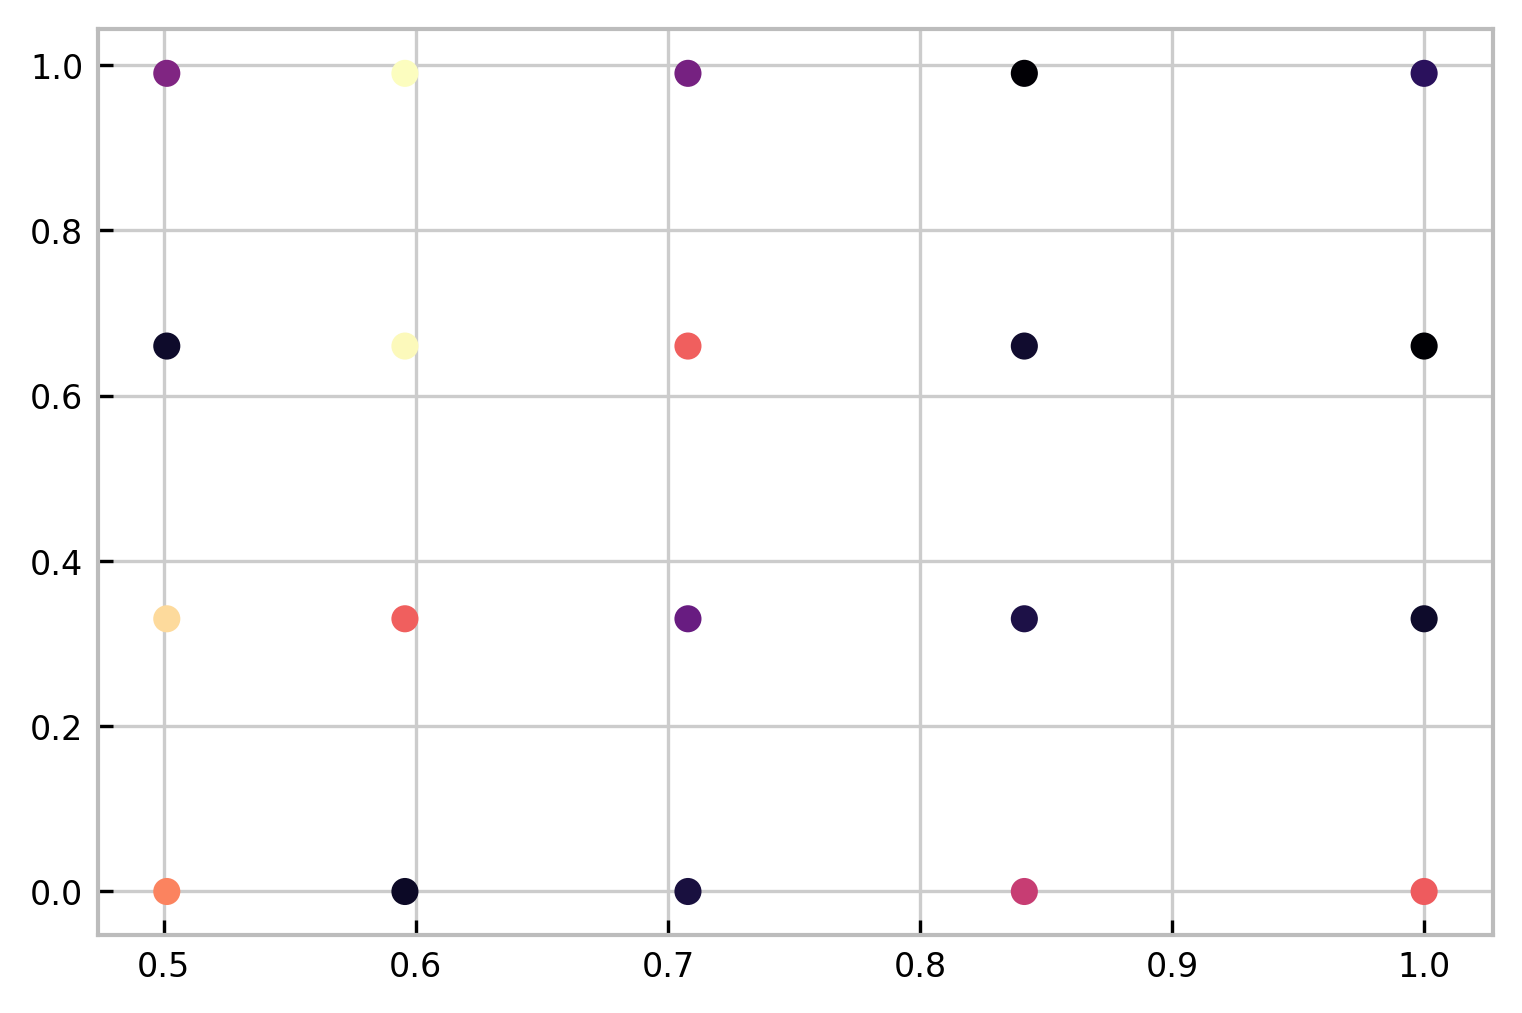

In [14]:
f, ax = plt.subplots(1,1, dpi=300, sharex=True, sharey=True)
po = ax.scatter(training[training[:,0]==0,1], training[training[:,0]==0,4],  
                c=training[training[:,0]==0,-1], cmap='magma')

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:1120: UserWarning: 'SourceCodePro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


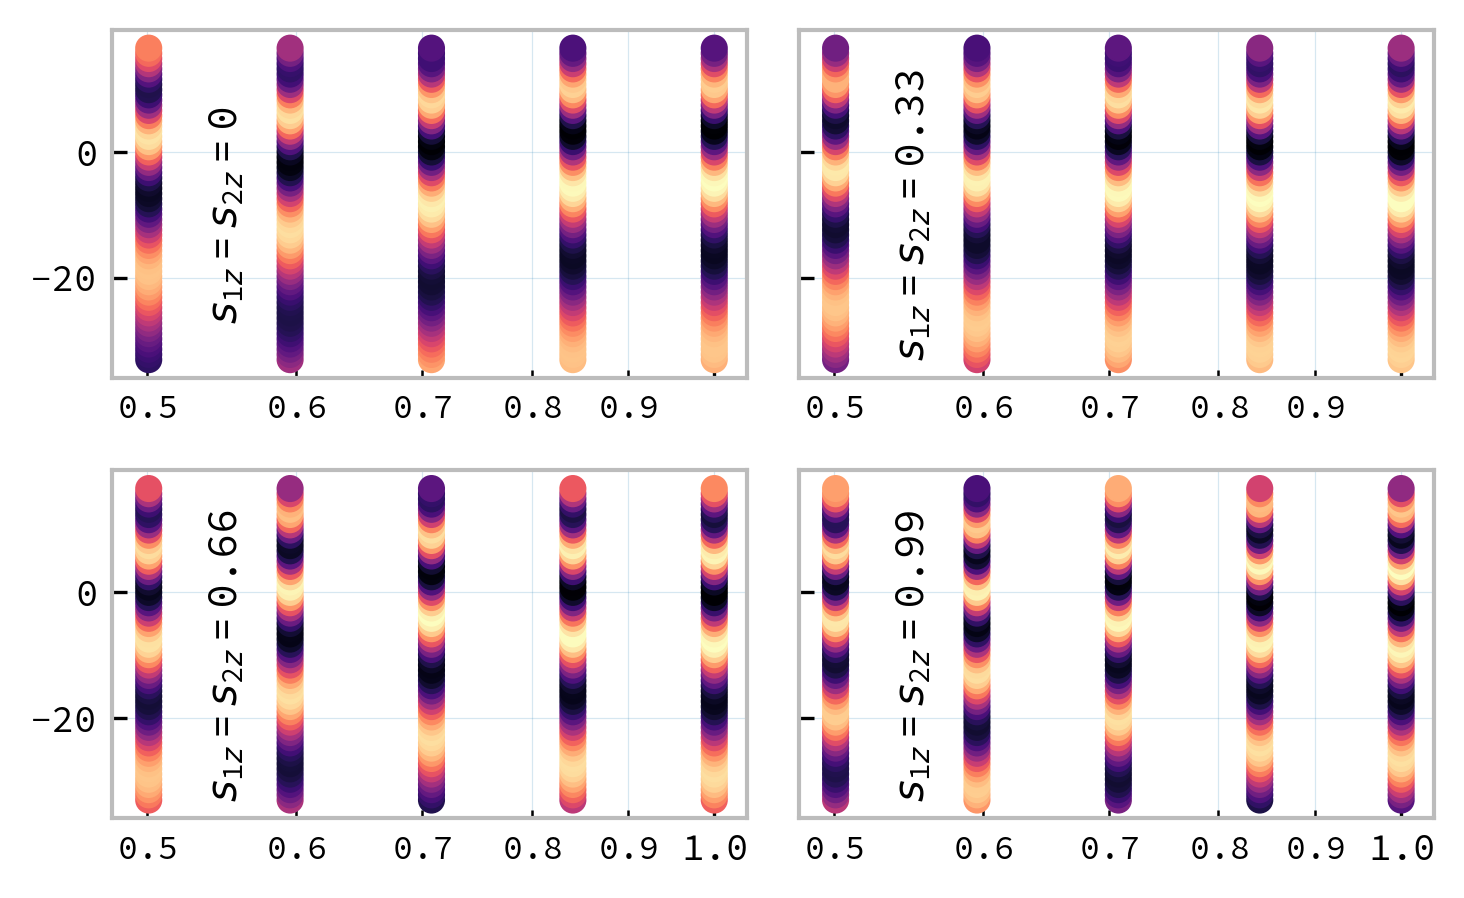

In [12]:
from matplotlib.ticker import StrMethodFormatter, ScalarFormatter, LogFormatter, LogFormatterSciNotation, EngFormatter
total_mass=60
h_factor = c.pc.value
time_factor = (c.c.value**3 / c.G.value)/(total_mass*c.M_sun.value) #*1e4
f, axes = plt.subplots(2,2, dpi=300, sharex=True, sharey=True)

for ax, spin in zip(axes.flatten(), [0,0.33, 0.66, 0.99]):
    training = imr_cat.create_training_data(total_mass=60., sample_rate=4096)
    training = training[training[:,4] == spin]
    po = ax.scatter(training[:,1], training[:,0]*time_factor,  c=h_factor*training[:,-1], cmap='magma')
    ax.set_xscale("log")
    ax.text(0.55, -10, "$s_{{1z}}=s_{{2z}}={}$".format(spin), rotation=90, ha="center", va="center")
    #formatter = StrMethodFormatter(r'$\mathfrac{%d}$')
    #formatter.set_scientific(False)
    #formatter.set_useMathText(False)
    
    ax.xaxis.set_minor_formatter(StrMethodFormatter(r'$\mathtt{{{x}}}$'))
    ax.xaxis.set_major_formatter(StrMethodFormatter(r'$\mathtt{{{x}}}$'))
    #ax.set_xlabel("Mass ratio")
    #ax.set_ylabel(r"$(t - t_{\rm peak})/M$")
#cax = plt.colorbar(po)
#ax.set_ylim([-40,20])
#cax.set_label(r"$r h_{2,2}$")
f = thesis.thesisify(f)
f.savefig("../../figures/heron/spin-test-training.pdf")

In [17]:
gp.training_data[:,0]

array([-2.49023438, -2.46582031, -2.44140625, ...,  1.92871094,
        1.953125  ,  1.97753906])

In [86]:
problem_dims = 8 # This model only has mass ratio and time in it
c_ind = imr_cat.c_ind
time_covariance = kernels.ExpSquaredKernel(195,
                                           ndim=problem_dims,
                                           axes=c_ind['time'],)
mass_covariance = kernels.ExpSquaredKernel(0.009, 
                                           ndim=problem_dims,
                                           axes=c_ind['mass ratio'])
spin_covariance = kernels.ExpSquaredKernel([0.05],
                                           ndim=problem_dims,
                                           axes=[c_ind['spin 1z']])
spin2z_covariance = kernels.ExpSquaredKernel([0.05],
                                           ndim=problem_dims,
                                           axes=[c_ind['spin 2z']])
covariance =  4 * mass_covariance * time_covariance * spin_covariance * spin2z_covariance

gp = gp_cat = waveform.GPCatalogue(imr_cat, covariance,
                                   total_mass=total_mass, fsample=4096,
                                   mean=0.0,
                                   ma=[(2,2)],
                                   solver="hodlr",
                                   tmax=0.02,
                                   tmin=-0.025,
                                   white_noise=1e-2,)

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:1120: UserWarning: 'SourceCodePro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


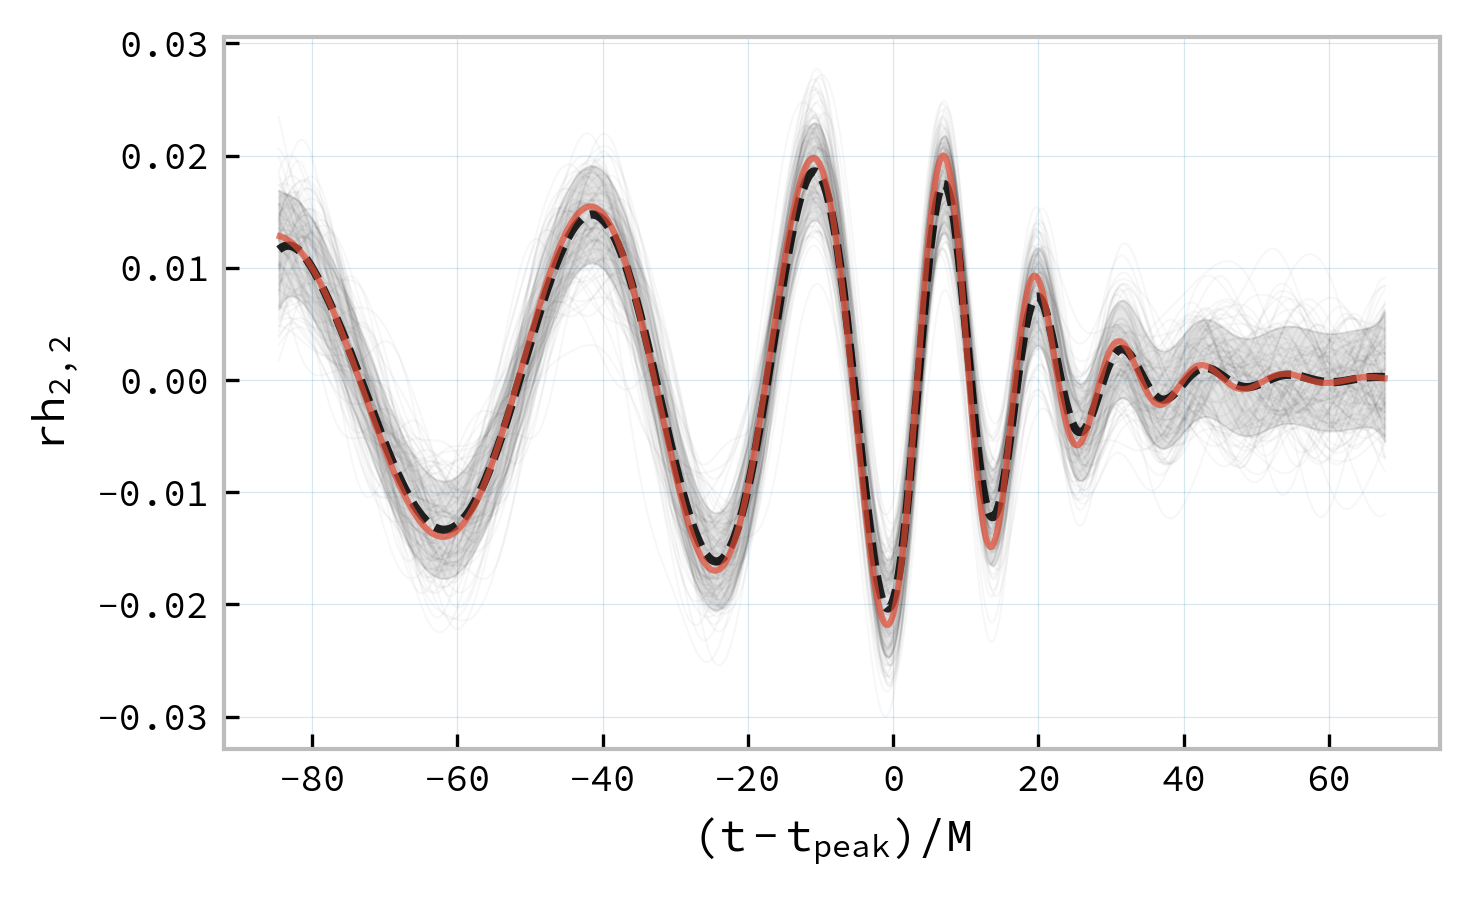

In [89]:
p = {"mass ratio": 0.8, "spin 1z":0., "spin 2z":0.}
f = sample_plot(p, surrogates=imr_cat)
f.savefig("../../figures/heron/imr-test-q0d8.pdf")

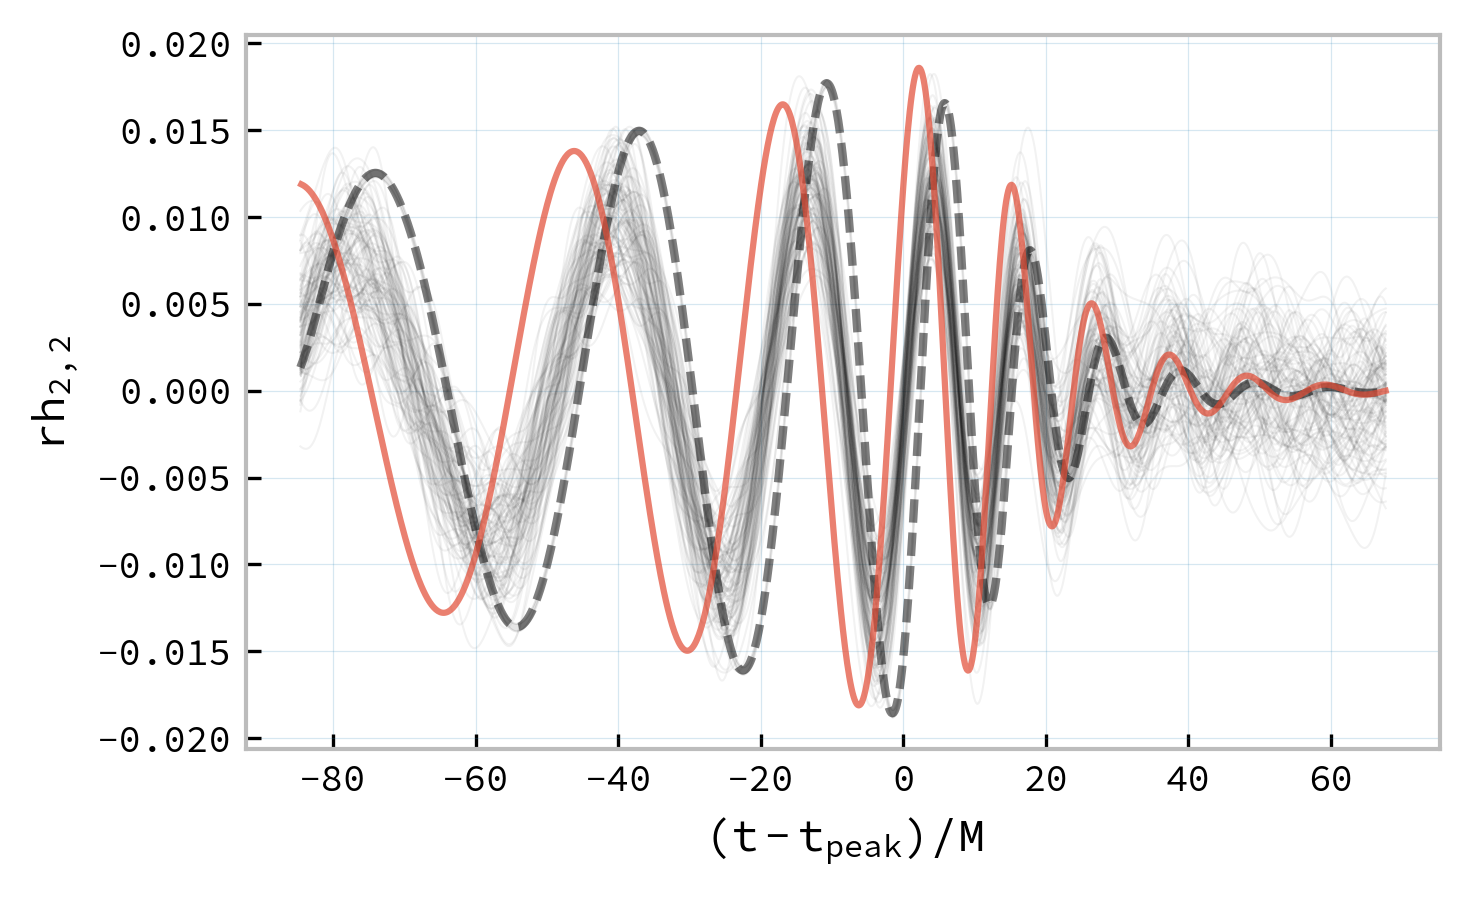

In [54]:
p = {"mass ratio": 0.8, "spin 1z": 0.35,  "spin 2z": 0.35, }
#"spin 1x":0, "spin 1y": 0, "spin 2x": 0, "spin 2y": 0}
f = sample_plot(p, surrogates=imr_cat)
#f.savefig("../../figures/heron/imr-test-q0d8.pdf")

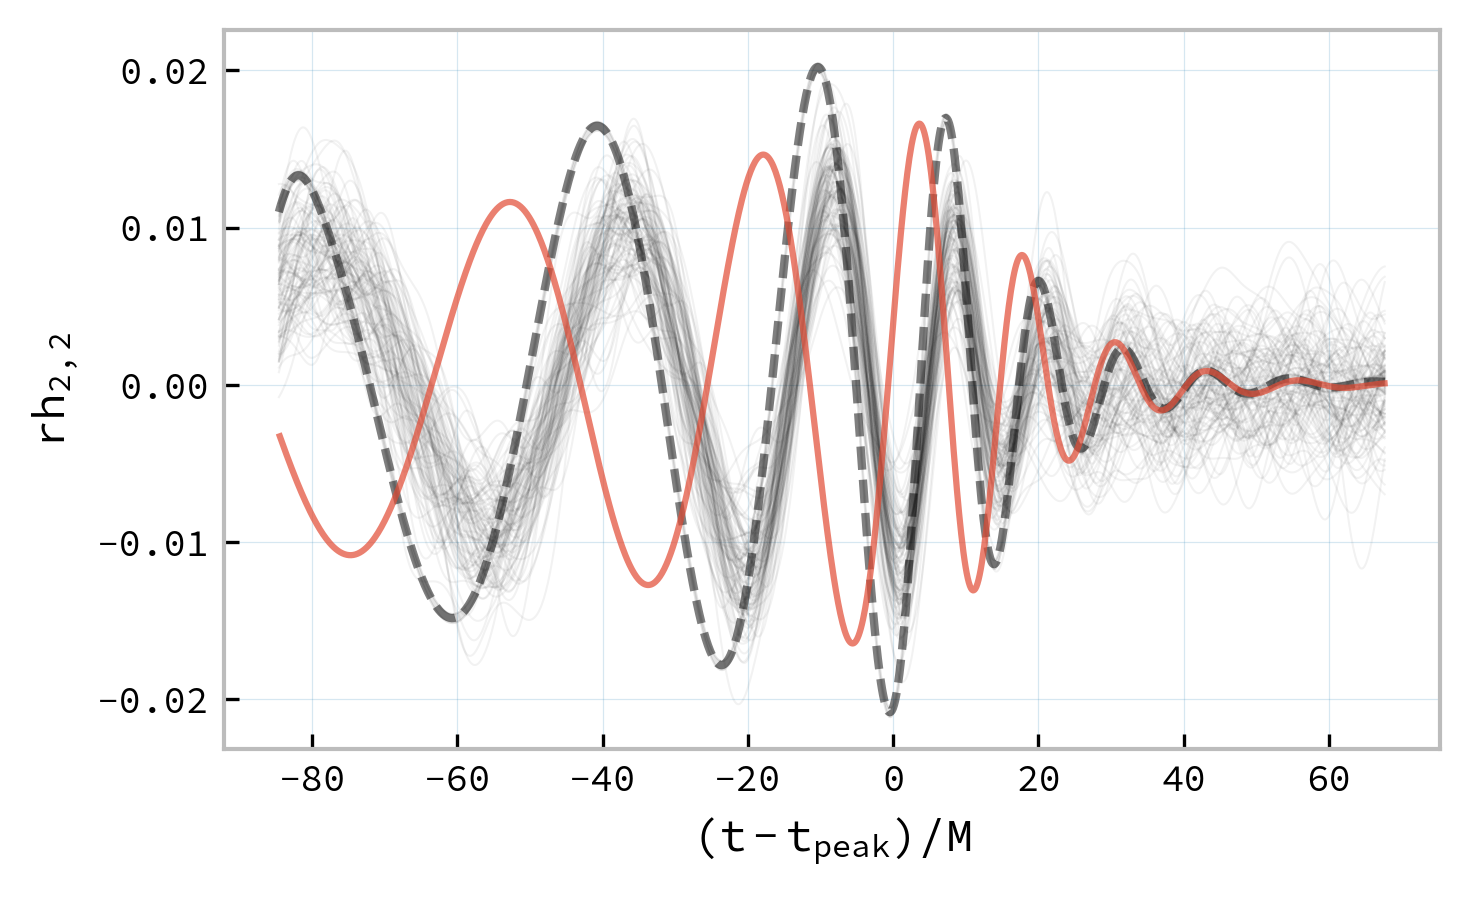

In [55]:
p = {"mass ratio": 1.0, "spin 1z": 0.00, "spin 2z": 0.00}
f = sample_plot(p, surrogates=imr_cat)
#f.savefig("../../figures/heron/imr-test-q0d8.pdf")

/home/daniel/.virtualenvs/IGRlaptop21/heron-stable/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:1579: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


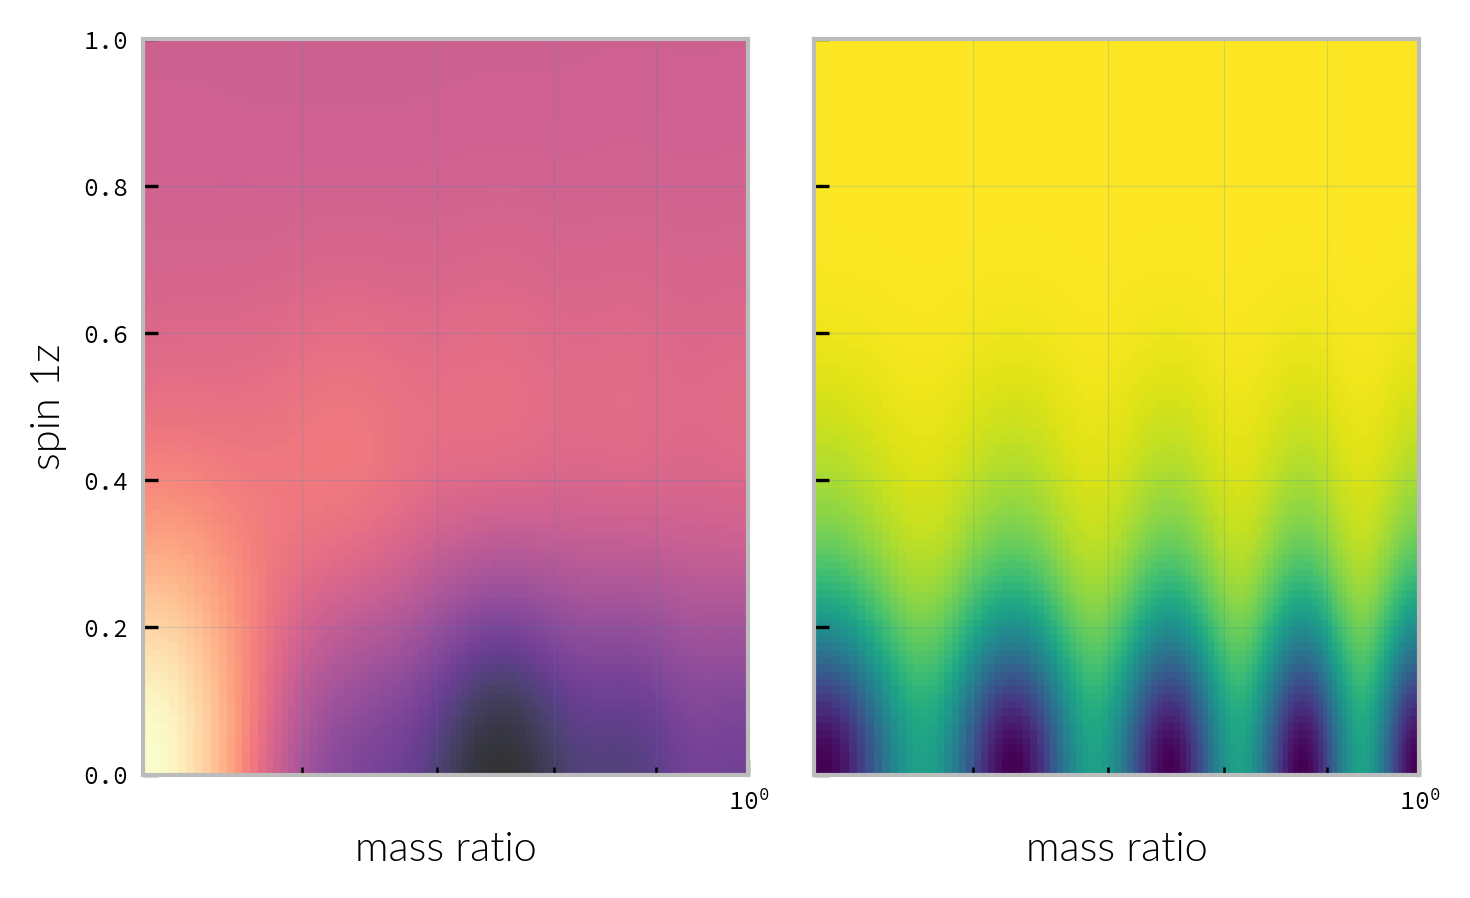

In [19]:
p = {"spin 1z": [0, 1.0, 100], "mass ratio": [np.log(0.5), np.log(1.0), 100], }
f, mean, var = plot_planes(p, fixed={"time": 0})
f = thesis.thesisify(f)
f.savefig("../../figures/heron/spin-test-plane-sm.pdf")

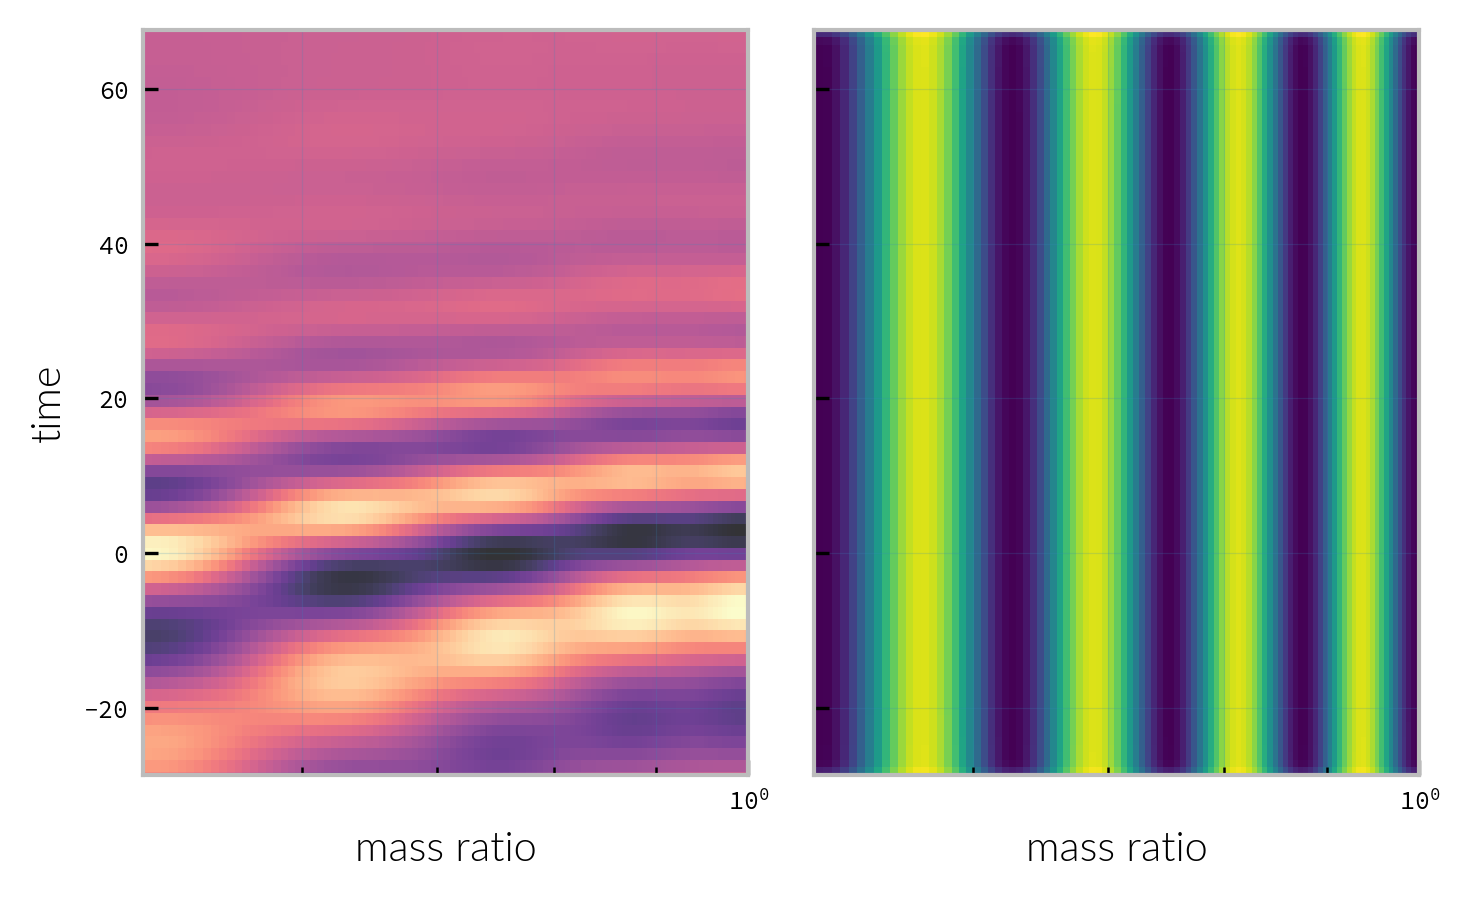

In [37]:
p = {"time": [-250, 200, 100], "mass ratio": [np.log(0.5), np.log(1.0), 100], }
f, mean, var = plot_planes(p, fixed={"spin 1z": 0.5})
f = thesis.thesisify(f)
f.savefig("../../figures/heron/spin-test-plane-mt.pdf")

In [20]:
import pycbc
import pycbc.psd

In [21]:
def match(a, b, psd=None):
    
    data_a = a.pycbc()
    data_b = b.pycbc()
    
    if psd == "aligo":
        f_low = 5
        f_delta = 1./16
        flen = int(2048/ f_delta) + 1
        psd = pycbc.psd.aLIGOZeroDetHighPower(flen, f_delta, f_low)
    
        return pycbc.filter.match(data_a, data_b, psd=psd)
    
    else:
        return pycbc.filter.match(data_a, data_b)

In [34]:
matches = []
for mass_ratio in np.linspace(0.65, 1.0, 25):
    for spin in np.linspace(0., 0.9, 25):
        p = {"mass ratio": mass_ratio , "spin 1z": spin, "spin 2z": spin}
        a = gp_cat.waveform(p=p, time_range=[-250.,200.,1024])
        p = {"mass ratio": mass_ratio, "spin 1z": spin, "spin 2z": spin}
        b = imr_cat.waveform(p=p, time_range=[-250.,200.,1024])

        matches.append(match(a[0],b[0]))
matches = np.array(matches)

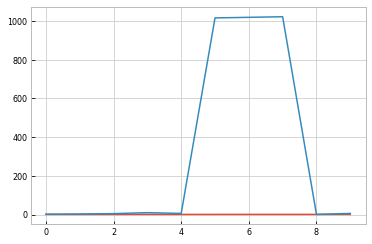

In [44]:
plt.plot(matches[:10])

In [51]:
matches[14]

array([ 0.80973202, 21.        ])

In [59]:
np.savetxt?

In [61]:
np.savetxt(fname="spin-matches.dat", X=matches[:,0])

In [30]:
matches.reshape([-1,2])

ValueError: cannot reshape array of size 625 into shape (2)

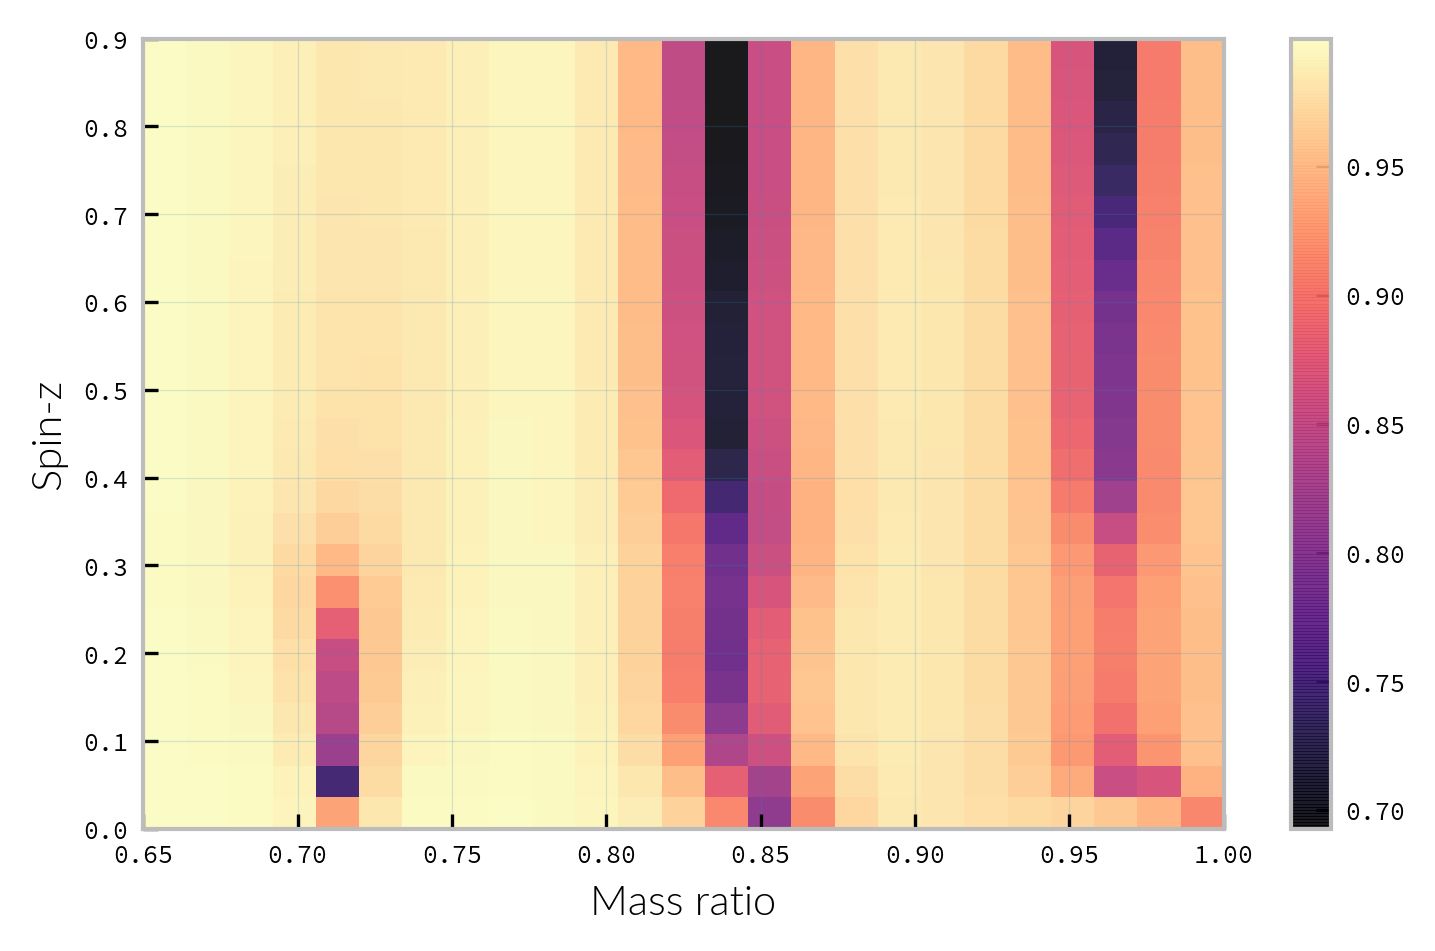

In [31]:
f, ax = plt.subplots(1,1, dpi=300)
matches = np.loadtxt("spin-matches.dat")
c = ax.imshow(matches.reshape(25,25), cmap='magma', 
           extent=(0.65, 1.0, 0.0, 0.90), origin='lower', 
          aspect='auto', alpha=0.9)
plt.colorbar(c)
f = thesis.thesisify(f)
ax.set_xlabel("Mass ratio")
ax.set_ylabel("Spin-z")
f.savefig("../../figures/heron/spin-test-ms-plane.pdf")

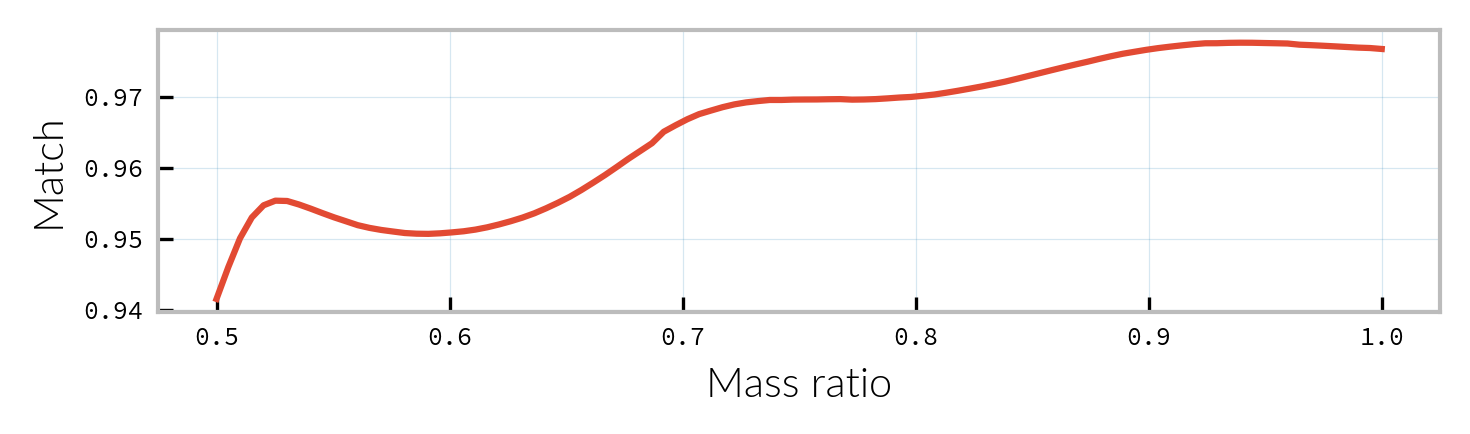

In [28]:
f, ax = plt.subplots(1,1, dpi=300)
ax.plot(np.linspace(0.5, 1.0, 100), matches[:,0])
ax.set_xlabel("Mass ratio")
ax.set_ylabel("Match")
f = thesis.thesisify(f, height=0.5)
f.savefig("../../figures/heron/spin-test-match.pdf")

In [38]:
pycbc.filter.match?

In [31]:
plt.imshow(mean)

NameError: name 'mean' is not defined

Iteration 0
Computing
Iteration 1
Computing


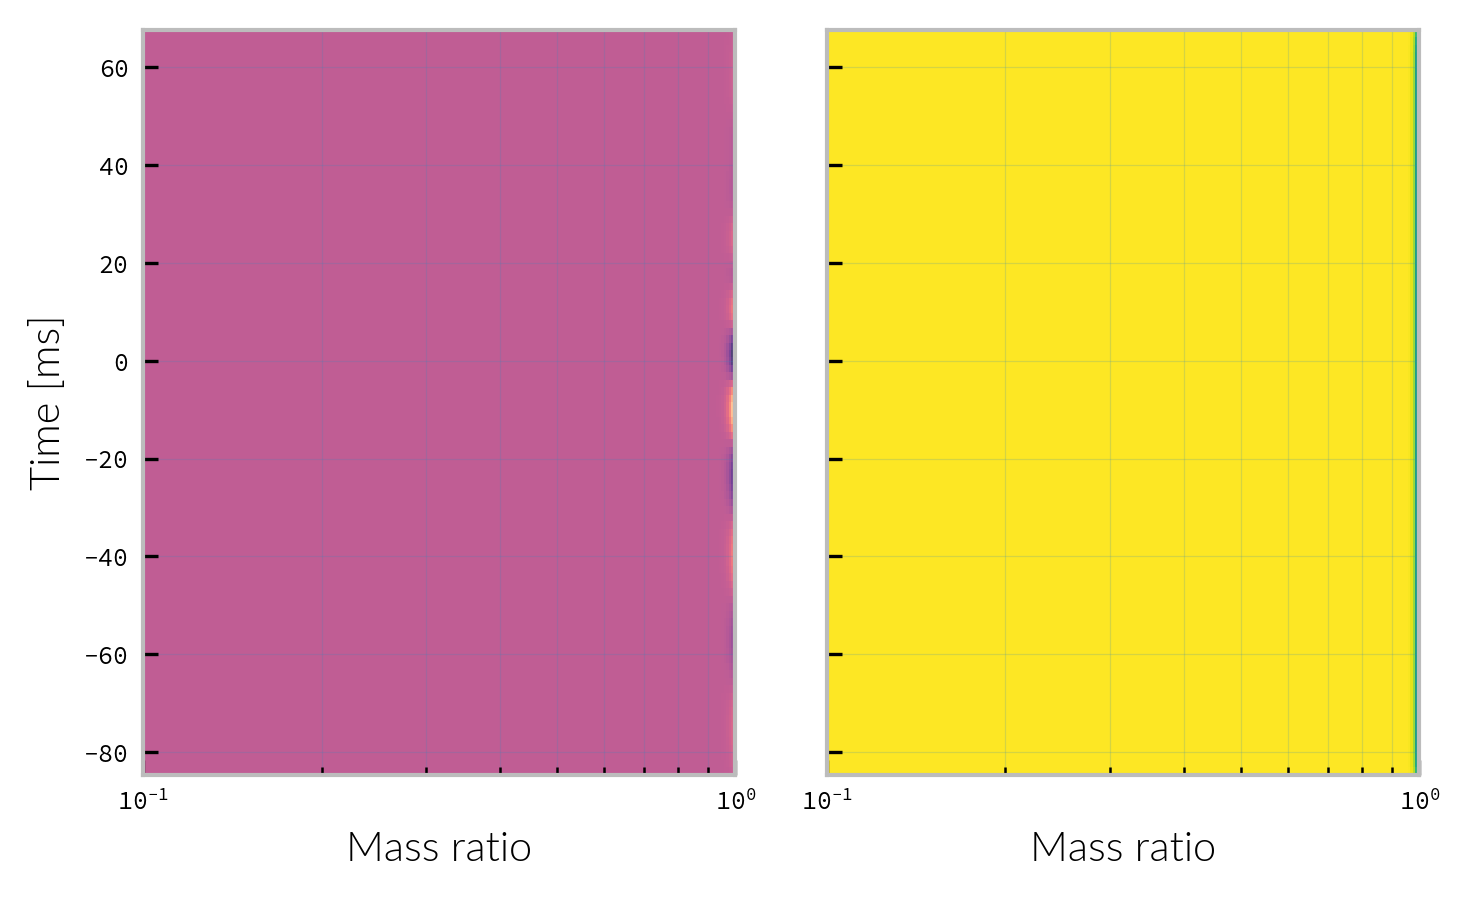

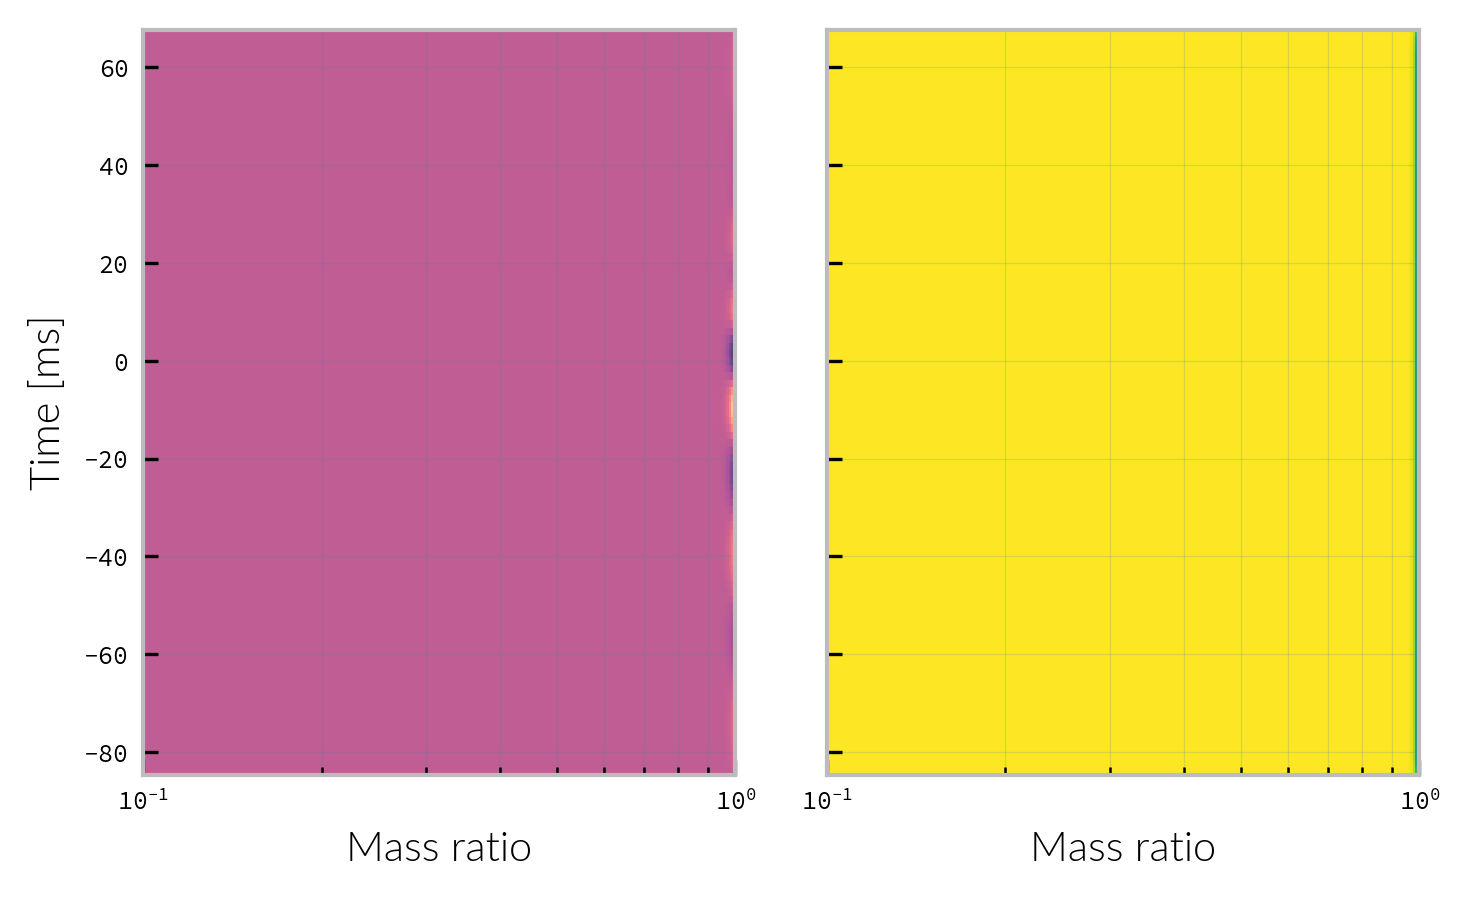

In [14]:
for i in range(2):
    print("Iteration {}".format(i))
    gp_cat.add_waveform(p={"mass ratio": np.logspace(-1,0,100)[var.sum(axis=0).argmax()], "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
    #gp_cat.optimise('bfgs', max_iter=2000)
    p = {"time": [-250, 200, 100], "mass ratio": [np.log(0.1), np.log(1.0), 100], }
    f, mean, var = plot_planes(p, fixed={})

Iteration 0
Computing
Iteration 1
Computing


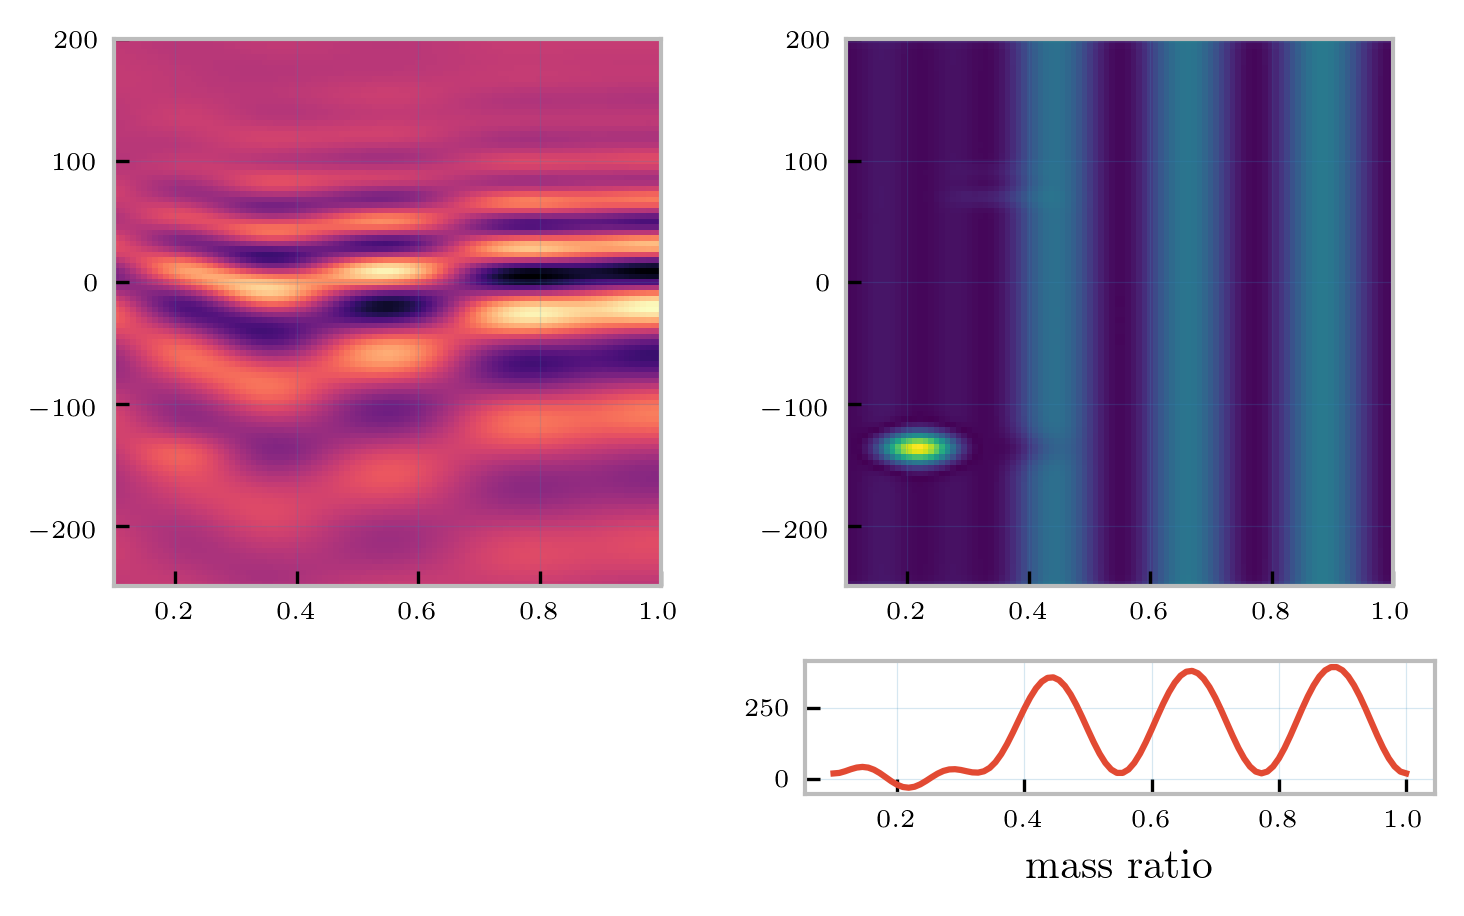

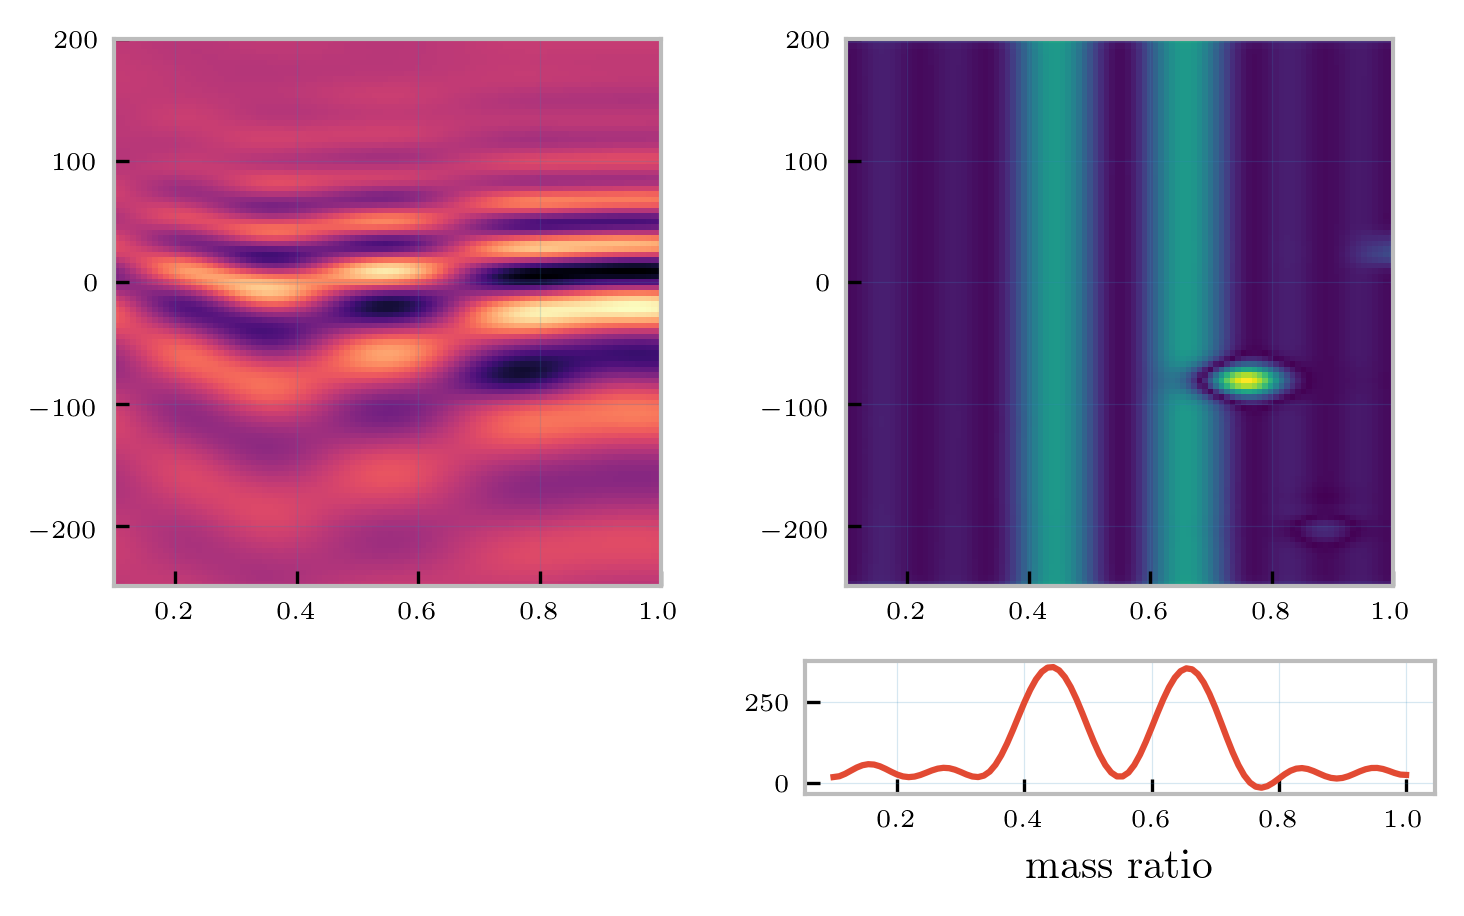

In [14]:
for i in range(2):
    print("Iteration {}".format(i))
    gp_cat.add_waveform(p={"mass ratio": np.linspace(0.1,1,100)[var.sum(axis=0).argmax()], "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
    #gp_cat.optimise('bfgs', max_iter=2000)
    p = {"time": [-250, 200, 100], "mass ratio": [0.1, 1.0, 100], }
    f, mean, var = plot_planes(p, fixed={})

Iteration 0
Computing
Iteration 1
Computing


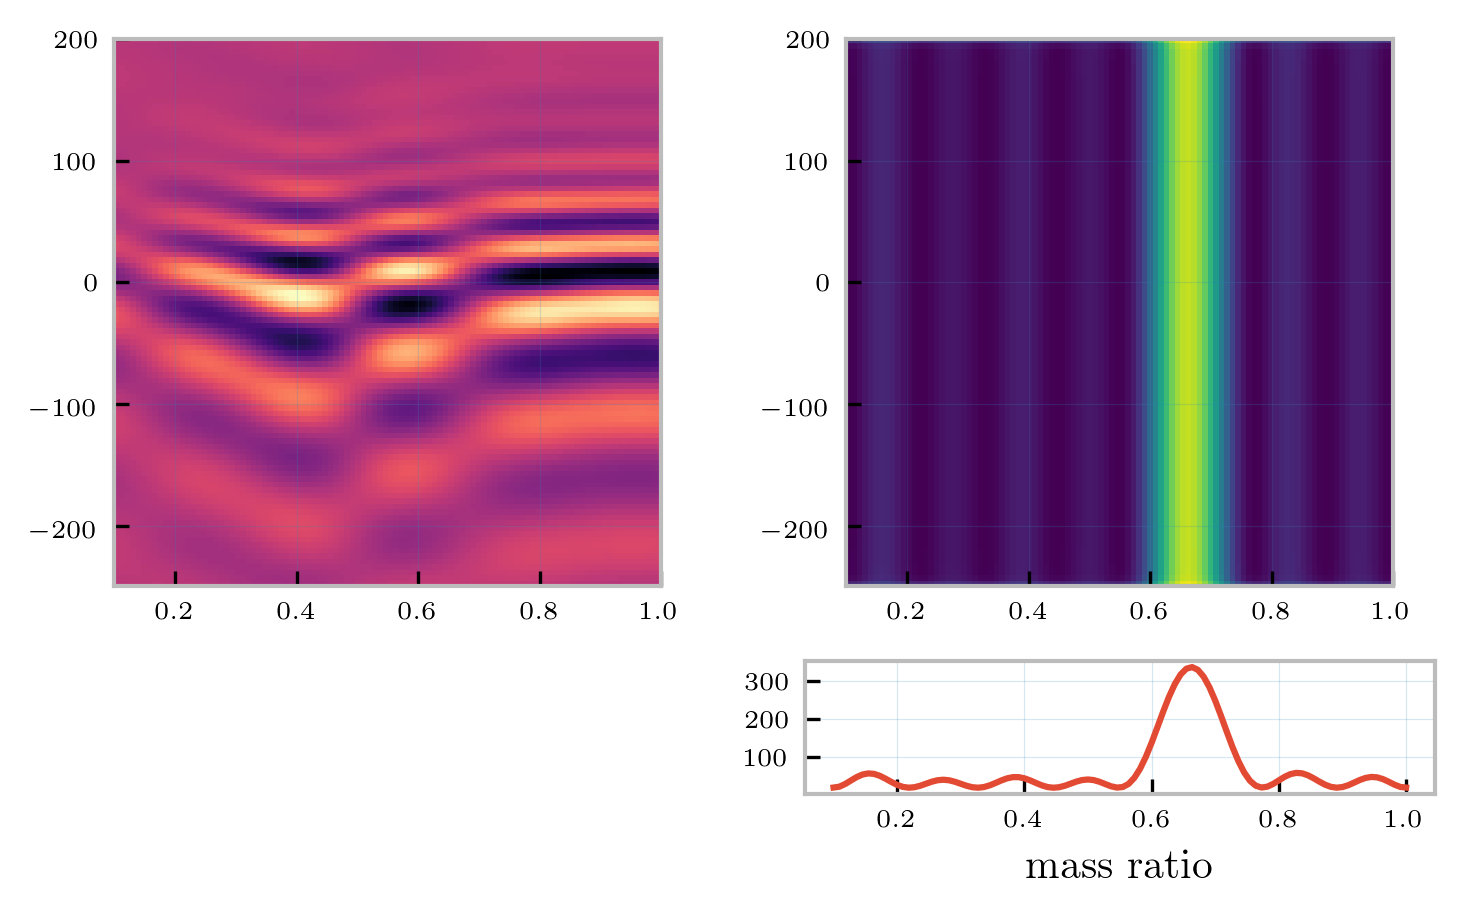

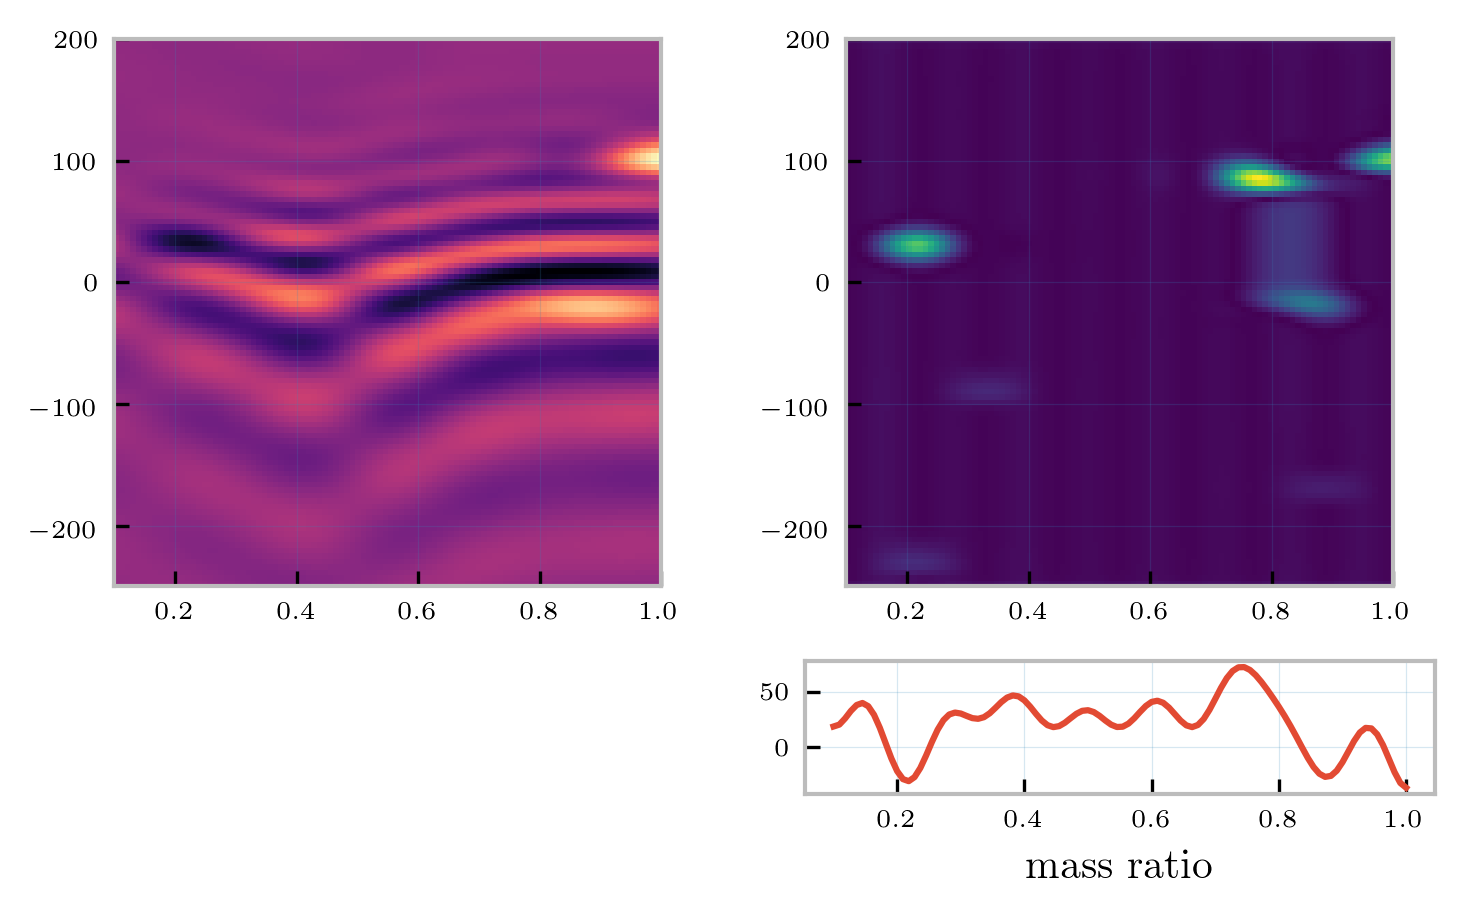

In [15]:
for i in range(2):
    print("Iteration {}".format(i))
    gp_cat.add_waveform(p={"mass ratio": np.linspace(0.1,1,100)[var.sum(axis=0).argmax()], "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
    #gp_cat.optimise('bfgs', max_iter=2000)
    p = {"time": [-250, 200, 100], "mass ratio": [0.1, 1.0, 100], }
    f, mean, var = plot_planes(p, fixed={})

Iteration 0
Computing
Iteration 1
Computing


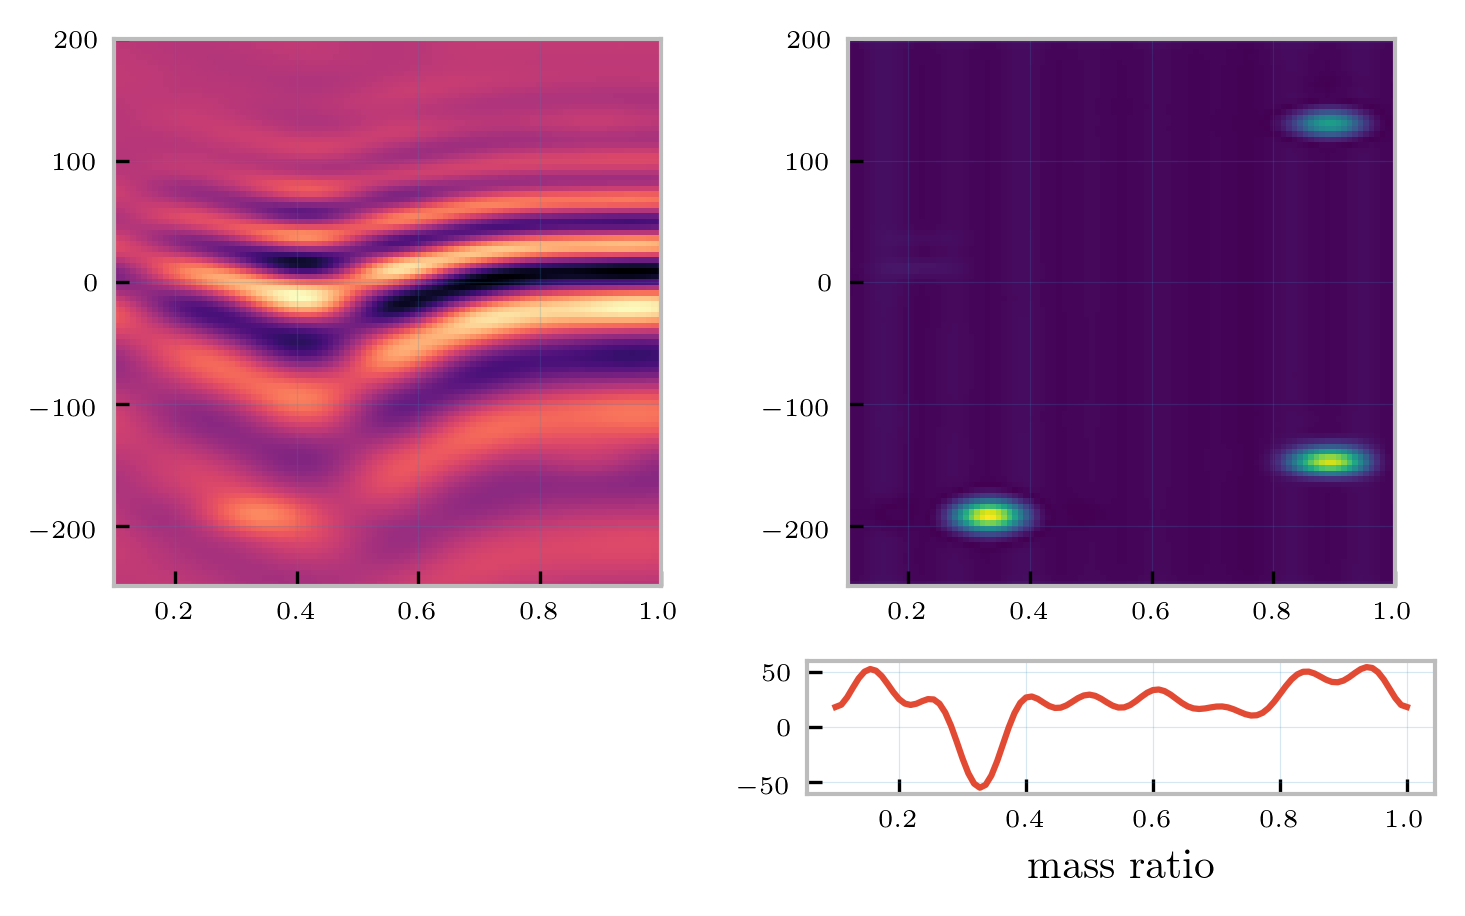

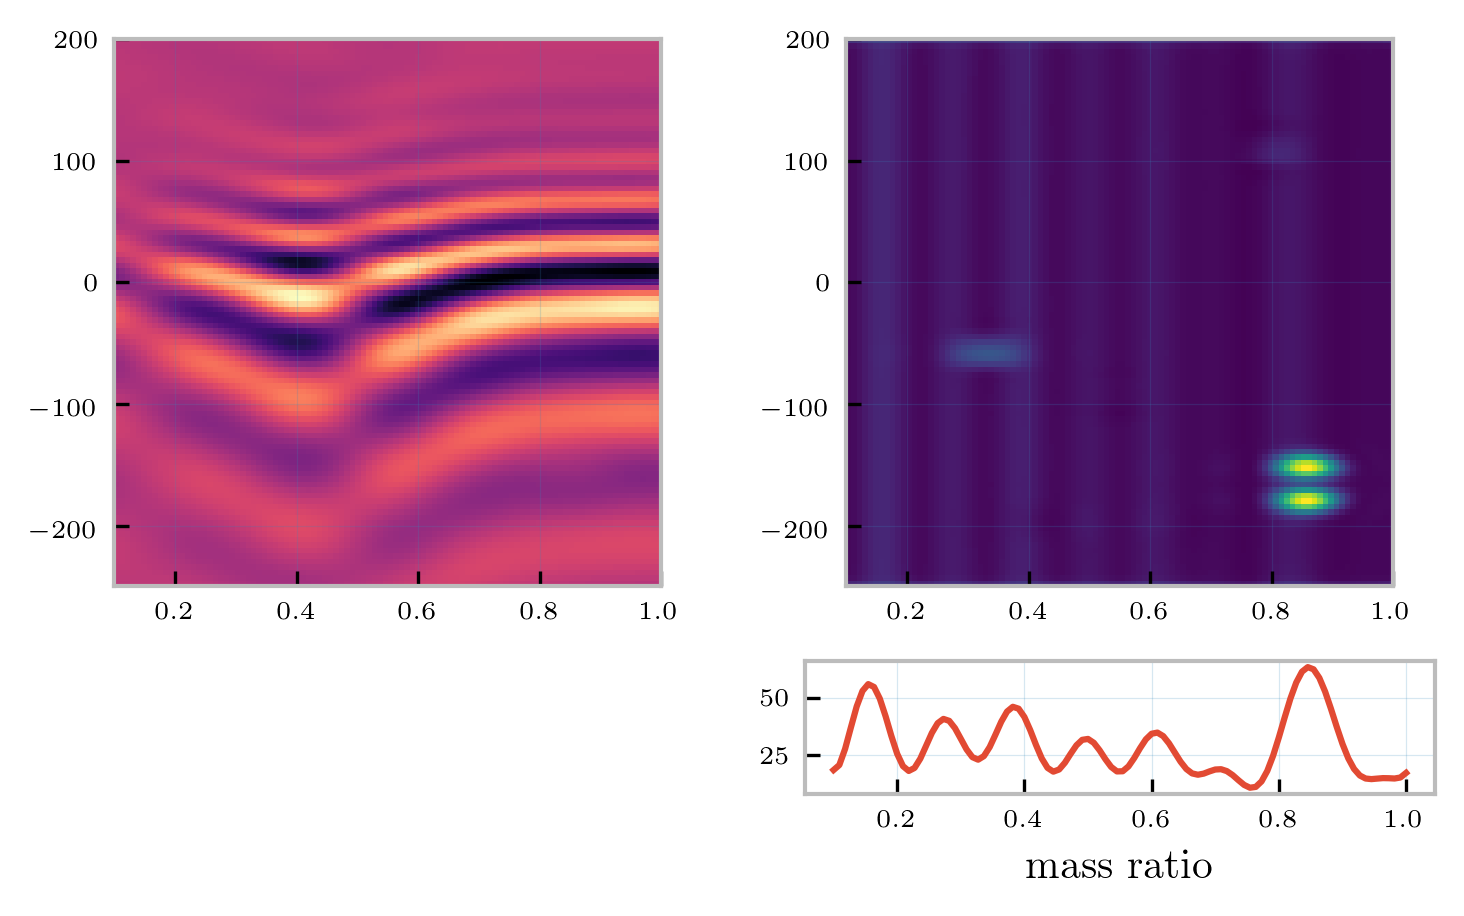

In [16]:
for i in range(2):
    print("Iteration {}".format(i))
    gp_cat.add_waveform(p={"mass ratio": np.linspace(0.1,1,100)[var.sum(axis=0).argmax()], "spin 1x":0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})
    #gp_cat.optimise('bfgs', max_iter=2000)
    p = {"time": [-250, 200, 100], "mass ratio": [0.1, 1.0, 100], }
    f, mean, var = plot_planes(p, fixed={})